# DSCI 100-002 Project Final Report: Predicting Playing Time on MineCraft Based on Age and Player Experience
---

**Date:** April 5th, 2025

**Group 32:** Christine Choi, Austin Hart, Katherine Hsu, Jack Yan

## Introduction
---

### Background
Minecraft, a sandbox video game developed by Mojang Studios and released in 2011, has become a global phenomenon, engaging millions of players across all age groups on its versatile platform. One key metric of engagement is the total hours players spend in the game, which can vary widely depending on individual player characteristics. For our research, we used data that was provided by plaicraft.ai, which is led by The Pacific Laboratory for Artificial Intelligence (PLAI), a research group from the Department of Computer Science at the University of British Columbia. 

### Research question
One of the broad questions that the research group is interested in is knowing which "kinds" of players are most likely to contribute a large amount of data in order to target these players in their recruiting efforts. Specifically, the question we wanted to explore regarding this research objective is:

Can `Age` and `experience` predict `played_hours` in `players.csv`?

We chose the number of hours played as an outcome variable because the more time someone spends playing on the Minecraft server, the more their engagement is going to contribute to the recorded data. Moreover, we chose to look at age and experience as predictor variables because the combination of these two participant factors could help the researchers get a rough idea of the general audience to target in recruitment (e.g. teenagers that regularly play MineCraft).

### Description of dataset
The dataset that we used for this project is `players.csv`, which contains a total of 196 observations (i.e. information about 196 unique players). There are 7 variables which include:
- `experience` (character) - player's level of experience in the game (Beginner, Amateur, Regular, Pro, Veteran)
- `subscribe` (logical) - TRUE if player is subscribed to a game-related newsletter, FALSE if they are not subscribed
- `hashedEmail` (character) - player's email address scrambled into a unique code
- `played_hours` (double) - number of hours (to one decimal place) that the player has played the game
- `name` (character) - first name of the player
- `gender` (character) - player's gender (Male, Female, Non-binary, Prefer not to say, Agender, Two-spirited, Other)
- `Age` (double) - player's age as a number

For the purpose of our research question, the relevant columns are `Age`, `experience`, and `played_hours`. In the survey where the user fills out their personal information, those below the age of seven are unable to participate and the maximum age that someone can input is 99. Furthermore, level of experience was defined as:

1) Beginner - I'm completely new to Minecraft
2) Amateur - I've played a few hours of Minecraft
3) Regular - I regularly play Minecraft
4) Pro - I am experienced and pro Minecraft player
5) Veteran - Been here since the old days. (Before 2015)

Some visible issues in the data file include:
- Values in the `Age` column containing "NA" instead of a number which could be an issue for applying computations since not all values in the column are the same data type.
- `experience` and `gender` having character data types which should be converted to factors since they are both categorical variables with distinct values.

Other potential issues that we noticed include:
- Values in the `hashedEmail` column differing in length and including both numbers and letters, which could present a challenge for functions requiring indexing.
- Each observation in `hashedEmail`being a unique code which could present challenges for filtering by this variable.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(2020)

### Loading the data

In [4]:
players <- read_csv('players.csv')
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Tidying & Wrangling

The `players_tidy` data frame was created by removing missing values from the full dataset using `na.omit()`. For the purposes of calculating on a regression model, the `experience` variable was then transformed from character type (e.g., "Beginner", "Pro", etc.) to numeric values ranging from 1 to 5. The numbers were assigned in the following manner: 1 for Beginner, 2 for Amateur, 3 for Regular, 4 for Veteran, and 5 for Pro. Finally, only three relevant columns — `experience`, `Age`, and `played_hours` — were selected for further analysis. Due to the large number of players who had 0 hours of recorded play time, the hours were converted to minutes for a more meaningful data visualization and analysis. This step ensured that the dataset was clean and structured for meaningful exploration.

In [5]:
players_tidy <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Veteran" ~ 4,
      experience == "Pro" ~ 5),) |>
    mutate(played_minutes = played_hours * 60) |>
    select(experience, Age, played_minutes)
head(players_tidy)

experience,Age,played_minutes
<dbl>,<dbl>,<dbl>
5,9,1818
4,17,228
4,17,0
2,21,42
3,21,6
2,17,0


### Summary Statistics

**Number of players with:**
- 100 or more hours of playtime = 4
- 0 hours of playtime = 85
  
**Average minutes played:**
- Beginner = 74.91
- Amateur = 361.05
- Regular = 1123.54
- Veteran = 38.88
- Pro = 167.08
  
**Age with the most amount of play time:**
- 16 years old (average minutes played = 3002.00)

**Average age:**
- Beginner = 21.66
- Amateur = 20.25
- Regular = 20.60
- Veteran = 20.96
- Pro = 16.92

In [12]:
players_with_zero <- players_tidy |>
    filter(played_minutes == 0) |>
    count()
as.numeric(players_with_zero)

[1] 85

In [13]:
players_over100 <- players_tidy |>
    filter(played_minutes > 6000) |>
    count()
as.numeric(players_over100)

[1] 4

In [8]:
experience_playtime_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_player_minutes = mean(played_minutes))
experience_playtime_means

experience,mean_player_minutes
<dbl>,<dbl>
1,74.91429
2,361.04762
3,1123.54286
4,38.87500
5,167.07692


The `experience_playtime_means` table was generated by grouping `players_tidy` by `experience` and calculating the average `played_hours` for each level. The results indicated that Regular players have the highest mean playtime (18.73 hours), while Veterans have the lowest (0.65 hours). This suggests that mid-tier players might be more engaged in the project server compared to beginners and highly skilled players.

In [19]:
age_playtime_means <- players_tidy |>
    group_by(Age) |>
    summarize(mean_player_minutes = mean(played_minutes))
age_playtime_means

Age,mean_player_minutes
<dbl>,<dbl>
8,18.00000
9,1818.00000
10,216.00000
11,174.00000
12,30.00000
14,522.00000
15,6.00000
16,3002.00000
17,285.44000


In [20]:
experience_age_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_age = mean(Age))
experience_age_means

experience,mean_age
<dbl>,<dbl>
1,21.65714
2,20.25397
3,20.60000
4,20.95833
5,16.92308


The `experience_age_means` data frame was created by grouping `players_tidy` by `experience` and computing the average `Age` for each level. The findings show that more experienced players tend to be younger, with Pro players averaging 16.92 years old. In contrast, Beginners have the highest mean age at 21.66 years. This may indicate that younger players reach higher skill levels faster.

### Exploratory Data Visualization

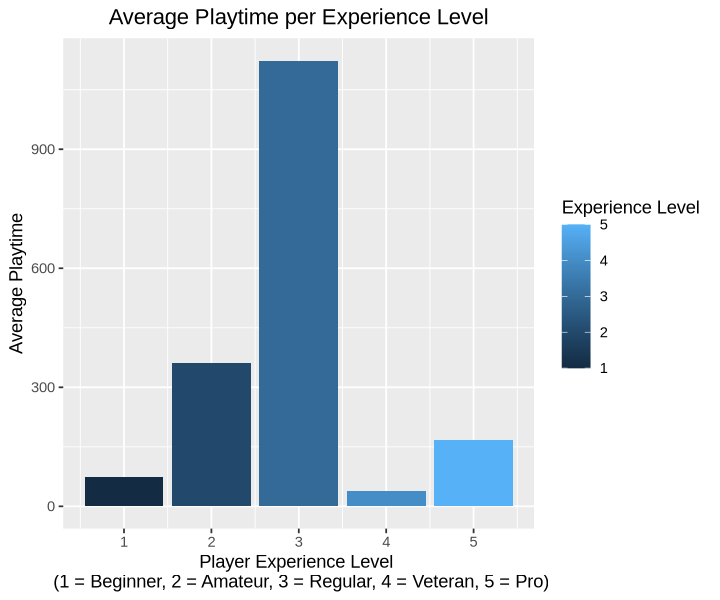

In [28]:
options(repr.plot.width = 6, repr.plot.height = 5)

experience_playtime_plot <- ggplot(experience_playtime_means, aes(x = experience, y = mean_player_minutes, fill = experience)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Player Experience Level \n (1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro)', 
         y = 'Average Playtime', 
         title = 'Average Playtime per Experience Level', 
         fill = 'Experience Level') +
    theme(plot.title = element_text(hjust = 0.5))
experience_playtime_plot

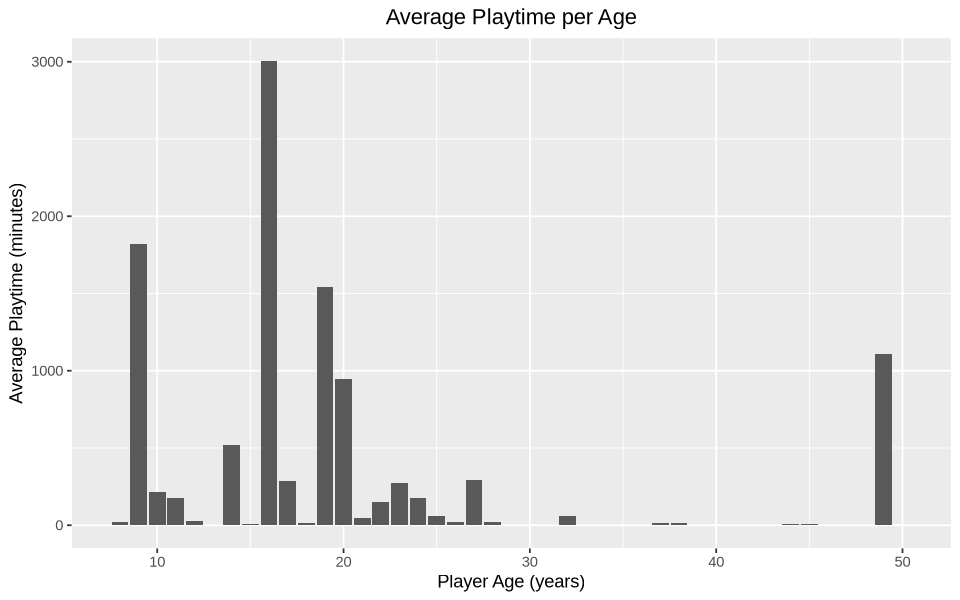

In [25]:
options(repr.plot.width = 8, repr.plot.height = 5)

age_playtime_plot <- ggplot(age_playtime_means, aes(x = Age, y = mean_player_minutes)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Player Age (years)', y = 'Average Playtime (minutes)', title = 'Average Playtime per Age') +
    theme(plot.title = element_text(hjust = 0.5))
age_playtime_plot

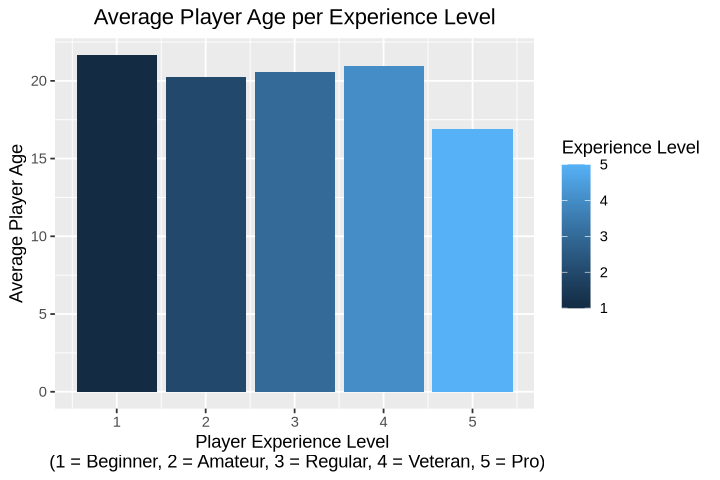

In [31]:
options(repr.plot.width = 6, repr.plot.height = 4)

experience_age_plot <- ggplot(experience_age_means, aes(x = experience, y = mean_age, fill = experience)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Player Experience Level \n (1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro)', 
         y = 'Average Player Age', title = 'Average Player Age per Experience Level', fill = 'Experience Level') + 
    theme(plot.title = element_text(hjust = 0.5))
experience_age_plot

## Methods
---
The method we used to analyze the amount of hours played is K-nearest neighbor (KNN) regression. Since both the predictor (the players’ age) and predicted (hours played) are quantitative variables, regression was the most appropriate in terms of prediction models. With the experience type, we were able to convert the various categories by labelling them with numbers (e.g. Beginner = 1, Amateur = 2, etc.) which is explained further in the Data Cleaning section. Furthermore, considering the trend observed in the exploratory visualization appears to be slightly curvilinear, we decided to use k-nearest neighbour regression rather than linear regression since KNN is not limited by non-linear data.

### Data splitting
The dataset `players_tidy` was split into training (75%) and testing (25%) sets using stratified sampling based on `played_hours`. A preprocessing recipe was created for the training data, where `experience` and `Age` are standardized using `step_scale()` and `step_center()`. These steps ensure that predictors are on a similar scale, preventing bias in the model due to differing units or magnitudes.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,rmse,standard,721.9759,5,274.9814,Preprocessor1_Model11


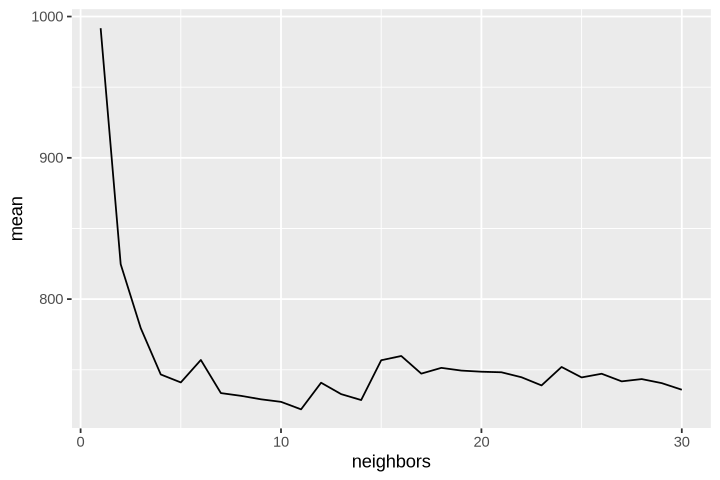

In [32]:
set.seed(2020)

players_split <- initial_split(players_tidy, prop = 0.75, strata = played_minutes)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(played_minutes ~ experience + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold = vfold_cv(players_train, v = 5, strata = played_minutes)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))
players_min
tuneplot <- ggplot(players_results, aes(x = neighbors, y = mean)) +
    geom_line()
tuneplot

### Model Specification, Cross-Validation, and Workflow Construction
A K-Nearest Neighbours (KNN) regression model was defined with neighbours as a tunable parameter and `weight_func` set to "rectangular". Next, five-fold cross-validation was applied to the training set using `vfold_cv()` and stratified by `played_hours` to ensure balanced sampling. This approach helped assess model performance across different data subsets while reducing overfitting. A machine learning workflow was then created by integrating the preprocessing recipe and KNN model specification. The `players_workflow` object streamlined data preprocessing and model training, making it ready for hyperparameter tuning and accurate prediction of `played_hours` based on `experience` and `Age`.

In [33]:
set.seed(2020)

players_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 11) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_minutes, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3089.235


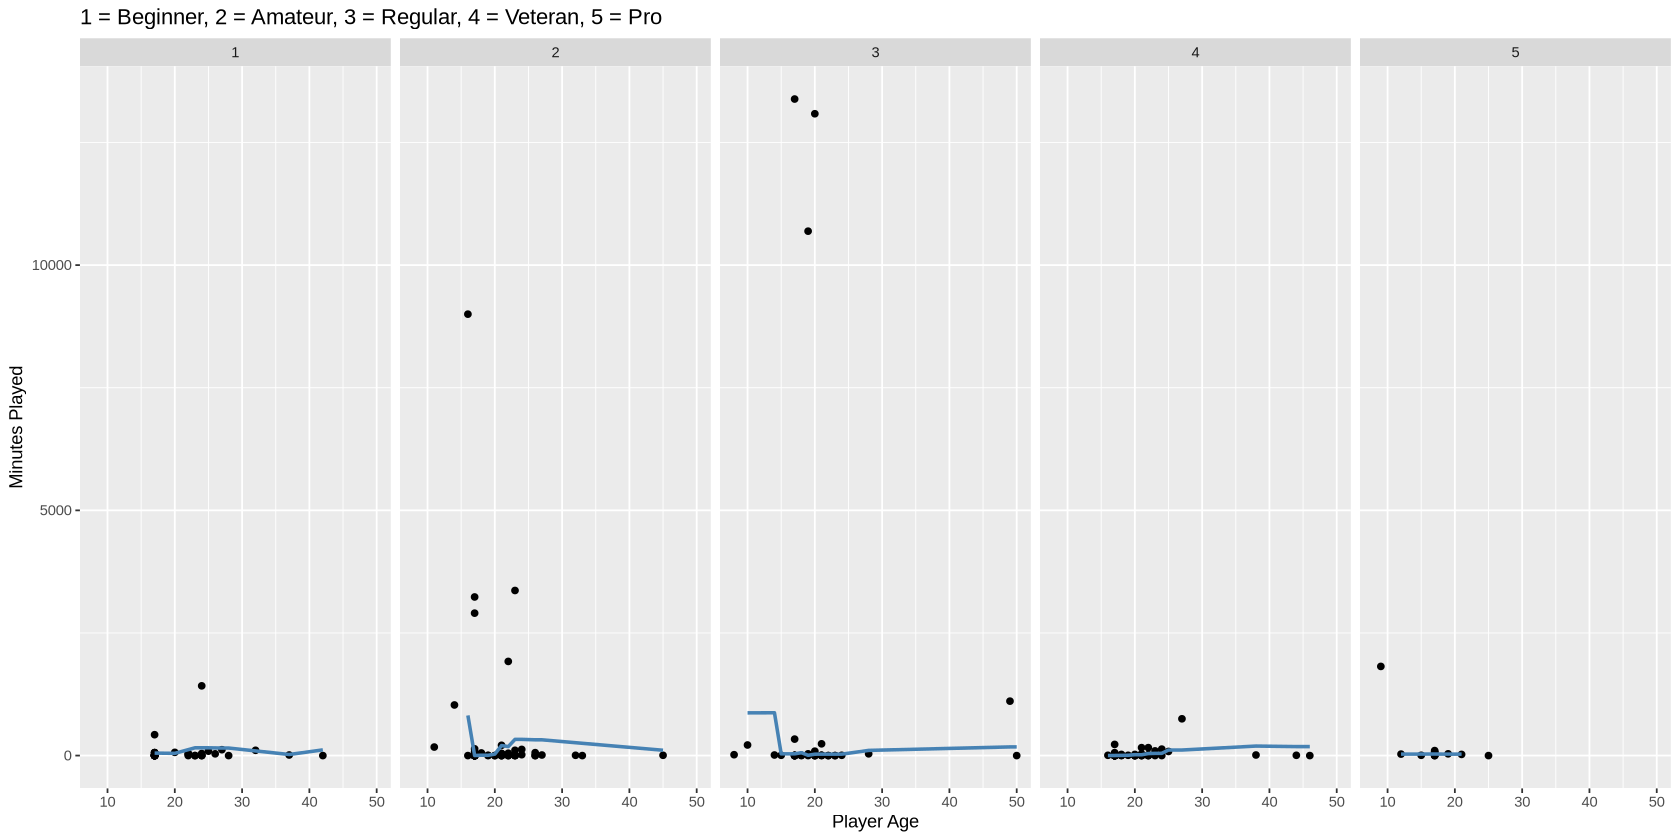

In [34]:
set.seed(2020)

players_preds <- predict(players_fit, players_train) |>
        bind_cols(players_train)

options(repr.plot.width = 14, repr.plot.height = 7)

players_plot <- ggplot(players_tidy, aes(x = Age, y = played_minutes)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Minutes Played") +
    ggtitle('1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro')

players_plot + facet_wrap(~experience, ncol = 5)

We then repeated these calculations but with the outliers removed. We defined an outlier as players who played more than 100 hours (6000 minutes).

In [36]:
players_no_outliers <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Veteran" ~ 4,
      experience == "Pro" ~ 5),) |>
    mutate(played_minutes = played_hours * 60) |>
    filter(6000 > played_minutes) |>
    select(experience, Age, played_minutes)
head(players_no_outliers)

experience,Age,played_minutes
<dbl>,<dbl>,<dbl>
5,9,1818
4,17,228
4,17,0
2,21,42
3,21,6
2,17,0


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,rmse,standard,466.0611,5,128.6576,Preprocessor1_Model04


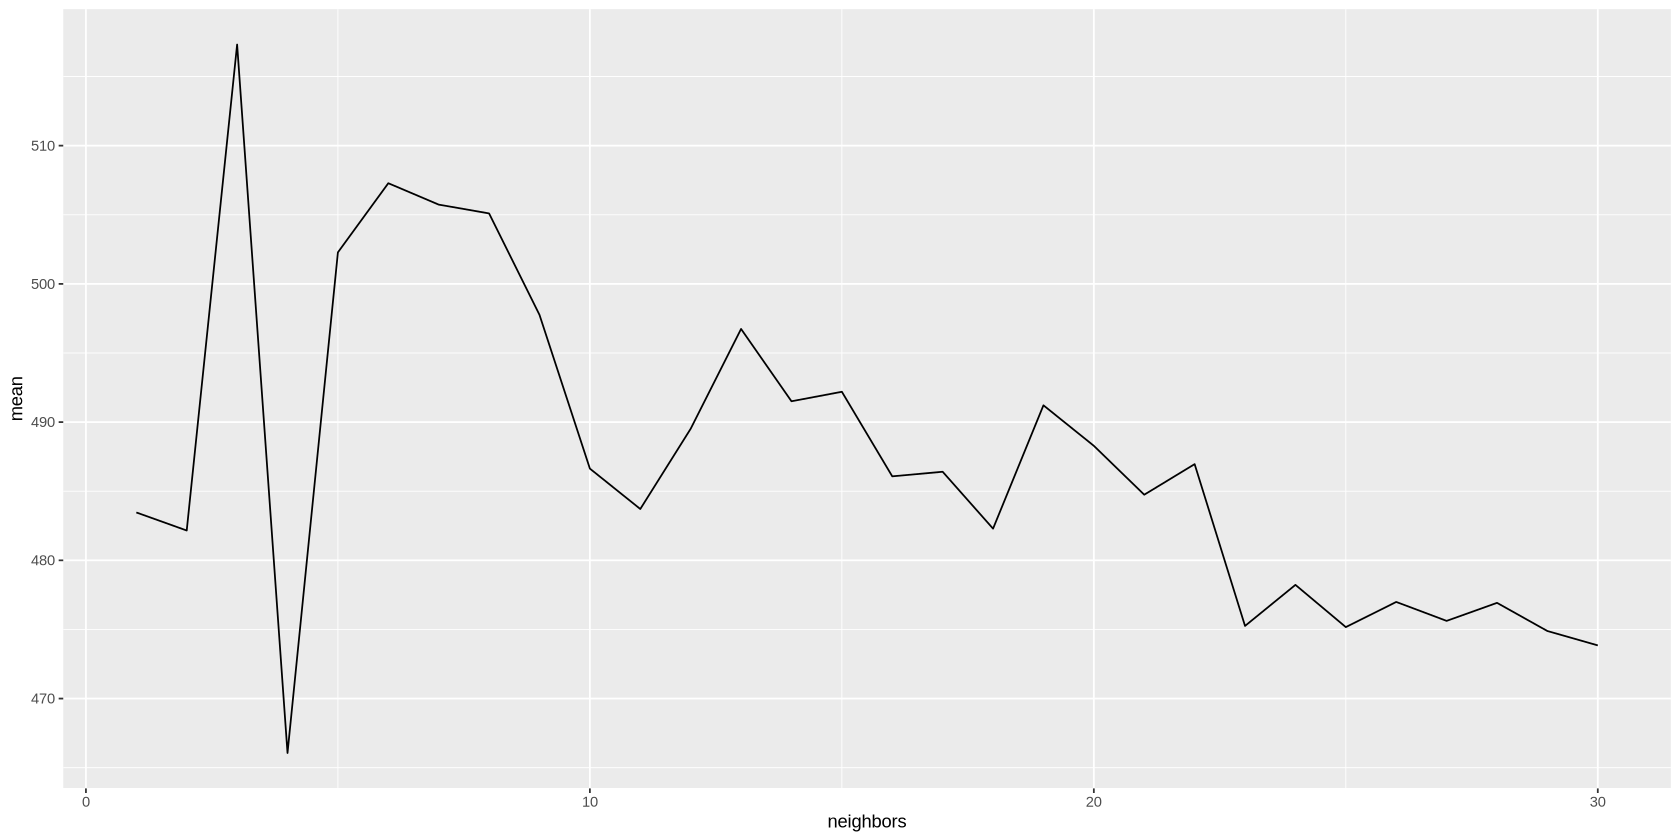

In [37]:
set.seed(2020)

players_split2 <- initial_split(players_no_outliers, prop = 0.75, strata = played_minutes)
players_train2 <- training(players_split2)
players_test2 <- testing(players_split2)

players_recipe2 <- recipe(played_minutes ~ experience + Age, data = players_train2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold2 = vfold_cv(players_train2, v = 5, strata = played_minutes)

players_workflow2 <- workflow() |>
    add_recipe(players_recipe2) |>
    add_model(players_spec_tune2)

gridvals2 <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

players_results2 <- players_workflow2 |>
  tune_grid(resamples = players_vfold2, grid = gridvals2) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_min2 <- players_results2 |>
    filter(mean == min(mean))
players_min2

tuneplot2 <- ggplot(players_results2, aes(x = neighbors, y = mean)) +
    geom_line()
tuneplot2

In [38]:
set.seed(2020)

players_spec2 <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 4) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit2 <- workflow() |>
    add_recipe(players_recipe2) |>
    add_model(players_spec2) |>
    fit(data = players_train2)

players_summary2 <- players_fit2 |>
  predict(players_test2) |>
  bind_cols(players_test2) |>
  metrics(truth = played_minutes, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,281.3893


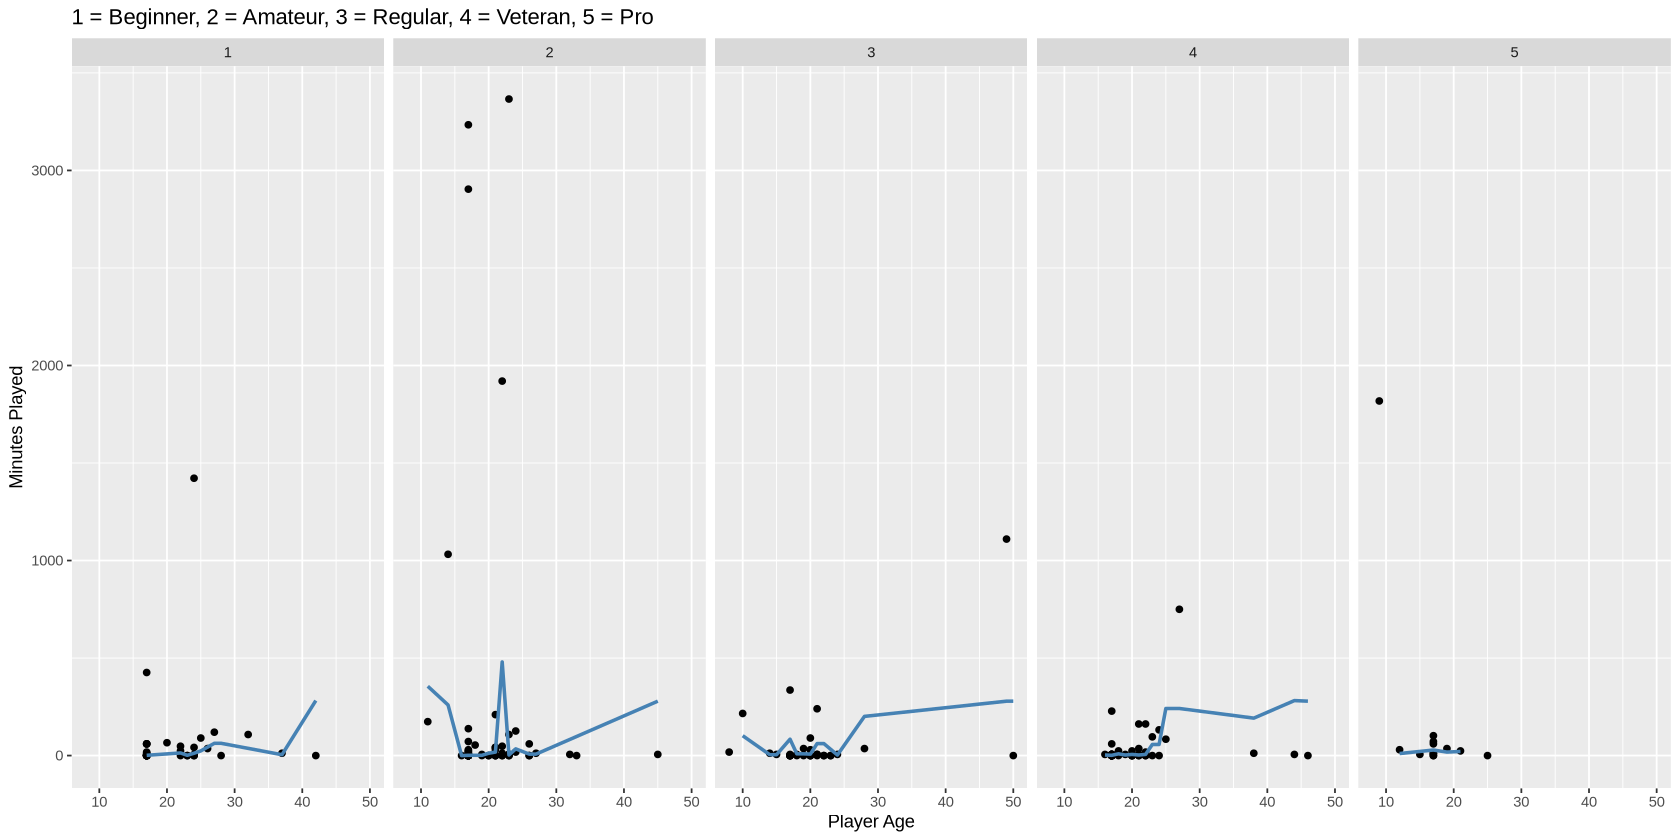

In [39]:
set.seed(2020)

players_preds2 <- predict(players_fit2, players_train2) |>
        bind_cols(players_train2)

options(repr.plot.width = 14, repr.plot.height = 7)

players_plot2 <- ggplot(players_no_outliers, aes(x = Age, y = played_minutes)) +
  geom_point() +
  geom_line(data = players_preds2,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Minutes Played") +
    ggtitle('1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro')

players_plot2 + facet_wrap(~experience, ncol = 5)

## Results
---

**Dataset and Processing:**
- Initial data: 196 rows, 7 columns from players.csv (experience, age, played hours, etc.); cleaned to 194 rows after removing NAs.
- Experience coded: 1 (Beginner) to 5 (Pro); played hours converted to minutes; outliers (≥6000 minutes) filtered out.
  
**Outlier Details:**
- All outliers (≥6000 minutes) fall in the "Regular" category (experience = 3).
- Specific outliers: Players around age 20 with >200 hours (12,000 minutes).

**Exploratory Insights:**
- Playtime peaks: Age 9 (1818 minutes), age 16 (3002 minutes).
- Mean age by experience: ~17–22 years; "Regular" likely skewed by outliers.

**Modeling Results:**
- KNN regression: Predicts played minutes using age and experience; minimum RMSE ~721.9759 (11 neighbors) without outliers.
- RMSE impact: With outliers, ~3000 minutes; without, ~500 minutes (significant drop).
- Prediction example: New player (experience = 5, age = 10) at 31.65–53.79 minutes.

**Challenges:**
- Persistent outliers: Smaller ones (e.g., >200 hours) remain after >6000-minute removal.
- Subset issues: "Regular" analysis failed due to insufficient data; many zero-playtime entries noted.

We found that due to the large number of players who played closer to zero hours, the prediction line remained mostly stagnant near the zero minutes of played. We suspected that it may be due to the few outliers, which 4 players had played over 100 total hours. 

## Discussion
---

In our hypothesis, we had suspected that higher experience and younger ages would link to a higher playtime. We also suspected that the outliers were contributing to skewing or conflating the data points, and after removing them, we found that the RMSE lowered. 

We found that the “regular” group of players fit a broad, sporadic player group and contributed to the data most, which aligned with what we had hypothesized. Similar to our hypothesis, removing the 4 outliers did result in improving the model slightly, as it showed that it was more sensitive to the variability of the play times.

There were some aspects that differed from our initial hypothesis. For example, even after removing the outliers with the large amount of play time, there were still outliers within the smaller data set, which also led to the model being affected. 

Overall, we found with the entire data set, age and experience may not be the most accurate predictor. With the outliers, the prediction model’s RMSPE was 3,089 minutes whereas without outliers its RMSPE was 281 minutes. 

Some of the challenges that we experienced with this data set is that it may not be representative of each type of player. For example, there was only one 9-year-old player and one 50-year-old player, which makes these age groups not represented fairly compared to those in the late teens or early 20s. Additionally, it was mentioned before that 85 players had zero minutes of playtime, which is one of the things that led to the prediction model’s high RMSPE (due to the large gap between these players and the outliers).

## References
---

Wikimedia Foundation. (2025, April 2). Minecraft. Wikipedia. https://en.wikipedia.org/wiki/Minecraft#:~:text=Minecraft%20is%20a%202011%20sandbox,released%20on%2017%20May%202009. 

Home Page. Pacific Laboratory for Artificial Intelligence. (2024a, December 5). https://plai.cs.ubc.ca/ 